# Similarity and Complementary Clustering

In [13]:
from src.data_processing import load_data, simulate_data, split_by_group_size
from src.similarity import *
from src.global_var import AVAILABLE, STRENGHTS, INTERESTS, GROUP_SIZE_VAR, INTEREST_VAR
from scipy.spatial.distance import euclidean, pdist, squareform
random_seed = 123
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load data or simulate data
sample_data = './data/sample_data.csv'
df = load_data(sample_data)

Empry dataframe
File not found. Please check the file and try again.


### 0) Load the data

In [3]:
# Load data or simulate data
# sample_data = './data/sample_data.csv'
# df = load_data(sample_data)

df = simulate_data(1000, save = True, save_dir = 'data/simulated_data.csv')

# Check that the data was loaded correctly
df.head(2)

,Do you have a preference in the size of the CoLearning Circle?,Which of the following competencies would you like to develop further?,aux_Which of the following competencies would you like to develop further?,Mondays (choice=8am-12pm),Mondays (choice=12pm-5pm),Mondays (choice=5pm-8pm),Tuesdays (choice=8am-12pm),Tuesdays (choice=12pm-5pm),Tuesdays (choice=5pm-8pm),Wednesdays (choice=8am-12pm),...,Nudging development with feedback.1,Onboarding new team members and integrating them into the team.1,Leading teams through organizational change.1,Dealing with staff and skill shortages,Addressing and resolving team conflicts.1,Finding information efficiently from trusted sources on the Internet.1,Facilitating virtual workshops.1,Effective virtual team collaboration.1,Maintain and expand professional network online.1,Record ID
0,keine Präferenz,Führungskompetenzen,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,7.0,4.0,0.0,0.0,0.0,0.0,0
1,Tandem (2 Personen),Kommunikative Kompetenzen,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [21]:
df['Which of the following competencies would you like to develop further?'].unique()

array(['Führungskompetenzen', 'Kommunikative Kompetenzen',
       'Digitale Kompetenzen'], dtype=object)

## 1) Split the data into 2 groups: Similarity and Complementary 

Print the group size preferences

In [4]:
# Group size preference 
df[GROUP_SIZE_VAR].value_counts()

Tandem (2 Personen)           474
Kleingruppe (3-6 Personen)    336
keine Präferenz               190
Name: Do you have a preference in the size of the CoLearning Circle?, dtype: int64

Print the interest preferences

In [6]:
df[INTEREST_VAR].value_counts()

Kommunikative Kompetenzen    512
Führungskompetenzen          277
Digitale Kompetenzen         211
Name: Which of the following competencies would you like to develop further?, dtype: int64

Concatenate the groups size and the interest preferences

In [7]:
df['stratify'] = df[GROUP_SIZE_VAR] + df[INTEREST_VAR]
df['stratify'].value_counts()

Tandem (2 Personen)Kommunikative Kompetenzen           245
Kleingruppe (3-6 Personen)Kommunikative Kompetenzen    168
Tandem (2 Personen)Führungskompetenzen                 137
keine PräferenzKommunikative Kompetenzen                99
Tandem (2 Personen)Digitale Kompetenzen                 92
Kleingruppe (3-6 Personen)Führungskompetenzen           87
Kleingruppe (3-6 Personen)Digitale Kompetenzen          81
keine PräferenzFührungskompetenzen                      53
keine PräferenzDigitale Kompetenzen                     38
Name: stratify, dtype: int64

Split in 2 groups: similarity and complementarity

In [8]:
# Statified split 
from sklearn.model_selection import train_test_split

df_sim, df_comp = train_test_split(df, test_size=0.5,
                                   random_state=random_seed,
                                   stratify=df['stratify'])

print(f"""{len(df_sim)} participants in the similarity group and {len(df_comp)} participants in the complementary group""")

500 participants in the similarity group and 500 participants in the complementary group


In [9]:
df_sim[[GROUP_SIZE_VAR]].value_counts()

Do you have a preference in the size of the CoLearning Circle?
Tandem (2 Personen)                                               237
Kleingruppe (3-6 Personen)                                        168
keine Präferenz                                                    95
dtype: int64

## 3) Split depending on group size 

In [10]:
df_sim_tandem, df_sim_kleingruppe  = split_by_group_size(df_sim)

Do you have a preference in the size of the CoLearning Circle?  group_size 
Tandem (2 Personen)                                             tandem         237
Kleingruppe (3-6 Personen)                                      kleingruppe    168
keine Präferenz                                                 kleingruppe     84
                                                                tandem          11
dtype: int64


In [11]:
df_comp_tandem, df_comp_kleingruppe  = split_by_group_size(df_comp)

Do you have a preference in the size of the CoLearning Circle?  group_size 
Tandem (2 Personen)                                             tandem         237
Kleingruppe (3-6 Personen)                                      kleingruppe    168
keine Präferenz                                                 kleingruppe     84
                                                                tandem          11
dtype: int64


In [12]:
# Report the number of participants in each group
print(df_sim_tandem[['group_size', INTEREST_VAR]].value_counts())


group_size  Which of the following competencies would you like to develop further?
tandem      Kommunikative Kompetenzen                                                 128
            Führungskompetenzen                                                        74
            Digitale Kompetenzen                                                       46
dtype: int64


## 4) Make groups
1. Contrains: At least one mutual available slot. 
2. Similarity. 



### 4.1) Similarity Tandom (df_sim_tandem)

In [16]:
interest = 'Digitale Kompetenzen'
df_sim_tandem_interest = df_sim_tandem[df_sim_tandem[INTEREST_VAR]==interest].copy()
m_available = np.array(df_sim_tandem_interest[AVAILABLE], dtype=bool)
available_count  = compute_availability(m_available)

# Boolean array indicating if the participants have one time slot in common 
not_available = np.array(available_count>=1, dtype=int)

In [28]:
not_available

array([[0, 1, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 0, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 0]])

In [29]:
# Compute similarity

if interest == 'Digitale Kompetenzen':
    features = INTERESTS[8:]
    feat_comp = STRENGHTS[8:]
elif interest == 'Führungskompetenzen':
    features = INTERESTS[4:8]
    feat_comp = STRENGHTS[4:8]
else: # Kommunikative Kompetenzen
    features = INTERESTS[:4]
    feat_comp = STRENGHTS[:4]

m_similarity = np.array(df_sim_tandem_interest[features], dtype=int)
# maximize this similarity
distance_s = squareform(pdist(m_similarity, metric='euclidean'))


# Competence shouldn't be too low: There;s nothing we can do about it
m_comp = np.array(df_sim_tandem_interest[feat_comp], dtype=int)
distance_c = squareform(pdist(m_comp, metric='euclidean'))

# how many times (percentage) the difference between the competence is higher than 3 
count_three = compute_difference(m_comp)/4

In [35]:
distance_s.shape

(46, 46)

In [412]:
# Distance between interests 
# + penality for not available
# + penality for gap in interests 
PENALTY_AVAILABILITY = 2 
PENALTY_GAP = 1
SIMILARITY_WEIGHT = 3

weighted_distance =  (
                     SIMILARITY_WEIGHT*(distance_s/np.max(distance_s)) + 
                     PENALTY_AVAILABILITY*not_available + 
                     PENALTY_GAP*(count_three/4)
                     )/(PENALTY_AVAILABILITY+PENALTY_GAP+SIMILARITY_WEIGHT)

weighted_distance

array([[0.        , 0.62569982, 0.60766955, ..., 0.65818022, 0.72344114,
        0.80668575],
       [0.62569982, 0.        , 0.58369949, ..., 0.57055479, 0.70449119,
        0.66941947],
       [0.60766955, 0.58369949, 0.        , ..., 0.43909626, 0.29379456,
        0.69008637],
       ...,
       [0.65818022, 0.57055479, 0.43909626, ..., 0.        , 0.63754456,
        0.67859506],
       [0.72344114, 0.70449119, 0.29379456, ..., 0.63754456, 0.        ,
        0.67278109],
       [0.80668575, 0.66941947, 0.69008637, ..., 0.67859506, 0.67278109,
        0.        ]])

In [413]:
weighted_distance

array([[0.        , 0.62569982, 0.60766955, ..., 0.65818022, 0.72344114,
        0.80668575],
       [0.62569982, 0.        , 0.58369949, ..., 0.57055479, 0.70449119,
        0.66941947],
       [0.60766955, 0.58369949, 0.        , ..., 0.43909626, 0.29379456,
        0.69008637],
       ...,
       [0.65818022, 0.57055479, 0.43909626, ..., 0.        , 0.63754456,
        0.67859506],
       [0.72344114, 0.70449119, 0.29379456, ..., 0.63754456, 0.        ,
        0.67278109],
       [0.80668575, 0.66941947, 0.69008637, ..., 0.67859506, 0.67278109,
        0.        ]])

In [420]:
import cvxpy 

def connect_point_cloud(d):
    '''
    Given a set of points computes return pairs of points that
    whose added distance is minimised
    '''
    N = d.shape[0];
    I, J = np.indices((N, N))
    
    use = cvxpy.Variable((N, N), integer=True)
    # each entry use[i,j] indicates that the point i is connected to point j
    # each pair may count 0 or 1 times
    constraints = [use >= 0, use <= 1];
    # point i must be used in at most one connection
    constraints += [sum(use[i,:]) + sum(use[:, i]) <= 1 for i in range(N)]
    # at least floor(N/2) connections must be presented
    constraints += [sum(use[i,j] for i in range(N) for j in range(N)) >= N//2];
    
    # let the solver  to handle the problem
    P = cvxpy.Problem(cvxpy.Minimize(sum(use[i,j] * d[i,j] for i in range(N) for j in range(N))), constraints)
    dist = P.solve()
    return use.value

### 4.2) Similarity Groups (df_sim_kleingruppe)

### 4.3) Complementary Tandom (df_comp_tandem)

### 4.4) Complementary Groups (df_comp_kleingruppe)

In [ ]:
## Failed attempts

In [421]:
res = connect_point_cloud(weighted_distance)

SolverError: 

                    You need a mixed-integer solver for this model. Refer to the documentation
                        https://www.cvxpy.org/tutorial/advanced/index.html#mixed-integer-programs
                    for discussion on this topic.

                    Quick fix 1: if you install the python package CVXOPT (pip install cvxopt),
                    then CVXPY can use the open-source mixed-integer linear programming
                    solver `GLPK`. If your problem is nonlinear then you can install SCIP
                    (pip install pyscipopt).

                    Quick fix 2: you can explicitly specify solver='ECOS_BB'. This may result
                    in incorrect solutions and is not recommended.
                

<AxesSubplot:>

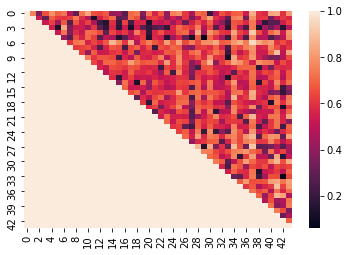

In [395]:
pairs_m = weighted_distance
np.fill_diagonal(pairs_m, 1)
num = pairs_m.shape[0]
ones = np.ones((num, num))
np.fill_diagonal(ones, 0)
pairs_m = np.tril(ones) + np.triu(pairs_m)
sns.heatmap(pairs_m)
#np.fill_diagonal(pairs_m, 1)

In [396]:
# Other ideas 
# Most similar sequential
label_index = []
labels_list = [] 
distance_list = []
group = 0

for i in range(num_pairs):
    smallest = np.unravel_index(pairs_m.argmin(), pairs_m.shape)
    distance = pairs_m[smallest]

    a = smallest[0]
    b = smallest[1]

    label_index.append(a)
    label_index.append(b)

    labels_list.append(group)
    labels_list.append(group)
    group += 1 

    distance_list.append(distance)
    distance_list.append(distance)

    pairs_m[:,a] = 1
    pairs_m[a,:] = 1

    pairs_m[:,b] = 1
    pairs_m[b,:] = 1


In [392]:
len(np.unique(label_index))

44

In [397]:
pd.DataFrame({'index': label_index, 'label': labels_list, 'distance': distance_list})

,index,label,distance
0,5,0,0.060858
1,29,0,0.060858
2,33,1,0.060858
3,42,1,0.060858
4,1,2,0.121716
5,11,2,0.121716
6,3,3,0.121716
7,17,3,0.121716
8,14,4,0.129099
9,18,4,0.129099


In the above output you can see the number of users that are in each group and their preferences. 
